In [1]:
import os
from os.path import join as oj
import sys, time
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import data_pecarn
import matplotlib.gridspec as grd
import data

# sns.set(style="black")
plt.style.use('dark_background')
%matplotlib inline
%load_ext autoreload
%autoreload 2

# look at all dsets

In [2]:
from data_pecarn import *
df_features = get_features()  # read all features into df
df_outcomes = get_outcomes()  # 2 outcomes: iai, and iai_intervention
df = pd.merge(df_features, df_outcomes, on='id', how='left')
df = rename_values(df)  # rename the features by their meaning

In [3]:
df2 = deepcopy(df)

In [4]:
ks_remap = ['Hispanic', 'VomitWretch', 'RecodedMOI', 
                'ThoracicTender', 'ThoracicTrauma', 'Costal', 
                'DecrBreathSound', 'AbdDistention', 'AbdTenderDegree',
                'AbdTrauma', 'SeatBeltSign', 'AbdTrauma_or_SeatBeltSign', 
                'DistractingPain', 'AbdomenPain']

In [5]:
# get without processing
'''
features = data_pecarn.get_features() # uses several forms
outcomes = data_pecarn.get_outcomes() # 2 outcomes: iai, and iai_intervention
d = pd.merge(features, outcomes, on='id', how='left')
'''

df_full = data_pecarn.get_data()
feat_names, pecarn_feat_names = data.get_feat_names(df_full)
# df = df_full[pecarn_feat_names + ['id', 'iai', 'iai_intervention']]
# df = rename_values(df)
# df = data.preprocess(features) # process the feats (should save into df)

computing pecarn preprocessing...


In [6]:
np.isnan(df_features.RecodedMOI).sum()

0

In [7]:
print(list(df_full[pecarn_feat_names].keys()))

['LtCostalTender', 'RecodedMOI', 'AbdTrauma', 'Age', 'Hypotension', 'DistractingPain', 'CostalTender', 'MOI', 'ThoracicTender', 'Sex', 'ThoracicTrauma', 'DecrBreathSound', 'GCSScore', 'VomitWretch', 'InitHeartRate', 'Race', 'SeatBeltSign', 'InitSysBPRange', 'RtCostalTender', 'AbdTrauma_or_SeatBeltSign', 'AbdTenderDegree', 'AbdDistention', 'AbdomenPain', 'GCSScore_Full']


### eda plots

In [ ]:
fnames = df.keys()
missing_arr = np.zeros((len(fnames), data_pecarn.NUM_PATIENTS + 1), dtype=np.bool)

for i, fname in enumerate(fnames):
#     df = r[fname]
    ids = np.unique(df.id.values)
#     print(np.min(ids), np.max(ids))
    missing_arr[i, ids] = 1
    
plt.figure(figsize=(5, 10))
sns.barplot(x=data_pecarn.NUM_PATIENTS - missing_arr.sum(axis=1), y=fnames, orient='h')
plt.xlabel('number of patients missing this feat')
plt.tight_layout()
plt.show()

/system/linux/anaconda3.7/lib/python3.7/site-packages/seaborn/matrix.py:682: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, max_dependent_coord * 1.05)


KeyboardInterrupt: 

<Figure size 3600x6000 with 0 Axes>

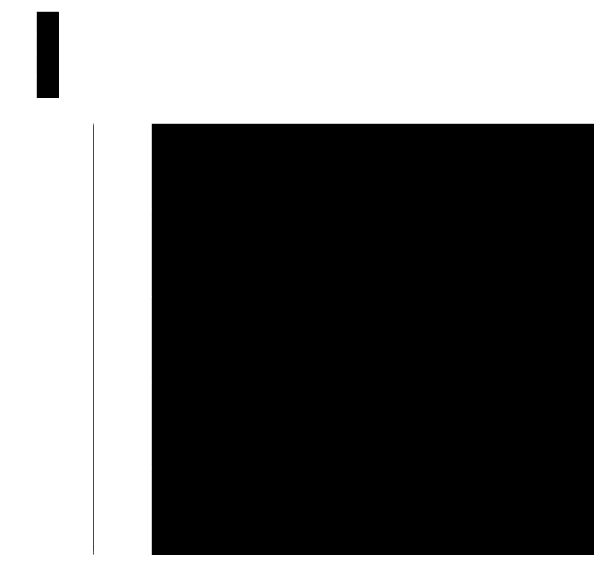

In [9]:
# plt.imshow(not_missing)
plt.figure(figsize=(12, 20), dpi=300)
sns.clustermap(missing_arr, yticklabels=fnames)
# plt.tight_layout()
plt.show()

In [ ]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
# sns.clustermap(corr) #, mask=mask, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

# look at demographics

In [ ]:
np.sum(d['iai_intervention'][d['iai']==1])

In [87]:
d.shape[0]

12044

In [16]:
d = df_full
ids_np = df.iai_intervention == 1
# print(list(d.keys()))

# the mean age is the only one which is wrong
print('iai', np.sum(d['iai']), np.sum(d['iai_intervention']))
print('age', np.mean(d.ageinyrs[ids_np]), np.mean(d.ageinyrs))
print('age<2', np.sum(d.ageinyrs[ids_np] < 2), np.sum(d.ageinyrs < 2))
print('sex', np.sum(d.SEX_M[ids_np]), np.sum(d.SEX_M))
print('hispanic ethnicity', np.sum(d.HISPANIC_ETHNICITY_0), np.sum(d.HISPANIC_ETHNICITY_1))

iai 761 203
age 9.339901477832512 9.767270009963468
age<2 10 1167
sex 125 7384
hispanic ethnicity 7656 3097


# correlations with outcome

In [73]:
df_filt = df.dropna(axis=1, thresh=1)

In [ ]:
X = df_full[['SEX_M', 'ageinyrs', 'GCSScore', 'iai', 'iai_intervention']]
sns.pairplot(X, hue='iai_intervention')
plt.show()

# misc important vars

In [ ]:
corrs_feat = df.corr(method='pearson')
cs = corrs_feat.iai_intervention.sort_values(ascending=False)
cs = cs[~cs.isnull()]
print(cs[:30], cs[-30:])

In [82]:
feat_names, pecarn_feat_names = data_pecarn.get_feat_names(df_full)

# dim reduction

In [9]:
df = data.get_data(use_processed=True)
feat_names, pecarn_feat_names = data.get_feat_names(df)
outcome_def = 'iai_intervention' # output

In [35]:
import prince
fca = prince.MCA(n_components=len(pecarn_feat_names)).fit(df[pecarn_feat_names])
comps = fca.transform(df[pecarn_feat_names]).head()

In [ ]:
# ax = mca.plot_coordinates(
#     df[pecarn_feat_names],
# #     color_labels=df[outcome_def]
# )
# ax.grid(False)

In [ ]:
def plot_fcs(fca, comps):

    # create a 2 X 2 grid 
    gs = grd.GridSpec(2, 2, height_ratios=[2,10], 
                      width_ratios=[12, 1], wspace=0.1, hspace=0)

#     try:
#     var_norm = pca.explained_variance_ / np.sum(pca.explained_variance_) * 100
    fca.explained_intertia
    # plot explained variance
    ax2 = plt.subplot(gs[0])
    ax2.bar(np.arange(0, comps.shape[1]), var_norm)
#     , color='black', width=0.8)
    plt.title('Explained variance (%)')
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
#         ax2.xaxis.set_visible(False)
    ax2.yaxis.set_ticks_position('left')
    ax2.set_yticks([0, max(var_norm)])
    plt.xlim((-0.5, comps.shape[1]-0.5))
#     except:
#         print('not pca')

    # plot pcs
    
    ax = plt.subplot(gs[2])
    p = ax.imshow(comps, interpolation='None', cmap='viridis',aspect='auto')
    plt.xlabel('PCA component number')

    # make colorbar
    colorAx = plt.subplot(gs[3])
    cb = plt.colorbar(p, cax = colorAx)

    plt.show()
    

# perform pca
# pca = decomposition.PCA()
# # pca = decomposition.NMF()
# pca.fit(df.transpose())
# comps = pca.components_.transpose()
# plt.figure(figsize=(6, 5))
plot_fcs(fca, comps)